In [1]:
from torchvision import datasets
import torch

In [2]:
# download the FMNIST training dataset
fmnist = datasets.FashionMNIST('~/data/FMNIST', download=True, train = True)

# fmnist validation dataset
val_fmnist = datasets.FashionMNIST('~/data/FMNIST', train = False)

In [3]:
# training dataset
tr_images  = fmnist.data

# validation datasets
val_images = val_fmnist.data

# training labels
tr_targets = fmnist.targets

# validation labels
val_targets = val_fmnist.targets

In [4]:
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [5]:
# build a class that fetch the dataset
class MyFMNISTDataset(Dataset):
    def __init__(self, x, y):
        
        # convert to float values, flatten
        # store them into the device
        x = x.float()/(255.*10000)
        x = x.view(-1, 28*28)
        self.x = x.to(device)
        self.y = y.to(device)
        
    def __getitem__(self, ix):
        return self.x[ix], self.y[ix]
    
    def __len__(self):
        return len(self.x)

In [6]:
# build a function to fetch a batchsize from the dataset
def get_data():
    # fetch the training dataset and the batches from itself
    trn_dts = MyFMNISTDataset(tr_images, tr_targets)
    trn_dl = DataLoader(trn_dts, batch_size=32, shuffle=True)
    
    # fetch the validation dataset and the batches from itself
    val_dts = MyFMNISTDataset(val_images, val_targets)
    val_dl = DataLoader(val_dts, batch_size=len(val_images), shuffle=False)
    return trn_dl, val_dl

In [7]:
from torch.optim import SGD, Adam

# define a model function
def get_model():
    class NeuralNetwork(nn.Module):
        def __init__(self):
            super().__init__()
            self.input_to_hidden_layer = nn.Linear(28*28, 1000)
            self.batch_norm = nn.BatchNorm1d(1000)
            self.hidden_layer_activation = nn.ReLU()
            self.hidden_to_output_layer = nn.Linear(1000, 10)
        
        def forward(self, x):
            x0 = self.input_to_hidden_layer(x)
            x1 = self.batch_norm(x0)
            x2 = self.hidden_layer_activation(x1)
            x3 = self.hidden_to_output_layer(x2)
            return x3, x2
            
    my_model = NeuralNetwork().to(device)
    
    #  Loss function
    loss_fn = nn.CrossEntropyLoss()
    
    # optimizer
    optimizer = Adam(my_model.parameters(), lr = 0.001)
    
    return my_model, loss_fn, optimizer

In [8]:
# function to train the dataset on a batch of images
def train_batch(batch_x, batch_y, my_model, loss_fn, optimizer):
    
    # flush the previous gradients
    optimizer.zero_grad()
    
    # compute the batch loss
    batch_loss = loss_fn(my_model(batch_x)[0], batch_y)
    
    # backward pass
    batch_loss.backward()
    
    # update parameters
    optimizer.step()
    
    return batch_loss.item()

In [9]:
@torch.no_grad()
def val_loss(val_batch_x, val_batch_y, my_model):
    val_batch_loss = loss_fn(my_model(val_batch_x)[0], val_batch_y)
    return val_batch_loss.item()

In [10]:
# compute the accuracy

# disable gradient computation in the whole function
@torch.no_grad()
def accuracy(batch_x, batch_y, my_model):
    
    # compute the max and the argmax
    max_values, argmaxes = my_model(batch_x)[0].max(-1)
    
    # coincide with ground truth
    is_correct = argmaxes == batch_y
    
    return is_correct.cpu().numpy().tolist()

In [11]:
trn_dl, val_dl = get_data()
my_model, loss_fn, optimizer = get_model()

In [12]:
import numpy as np
from torch.optim import lr_scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, factor = 0.2, patience = 0, 
                                           threshold = 0.001, min_lr = 0.00001,
                                           threshold_mode='abs',
                                           verbose=True)
# empty list of the total losses
losses, accuracies = [], []
val_losses, val_accuracies = [], []

for epoch in range(100):
    batch_losses, batch_accuracies = [], []
    
    for ix, (batch_x, batch_y) in enumerate(iter(trn_dl)):
        
        batch_loss = train_batch(batch_x, batch_y, my_model, loss_fn, optimizer)
        
        batch_losses.append(batch_loss)
    train_epoch_loss = np.array(batch_losses).mean()
    
    for ix, batches in enumerate(iter(trn_dl)):
        batch_x, batch_y = batches
        
        batch_accuracy = accuracy(batch_x, batch_y, my_model)
        
        batch_accuracies.extend(batch_accuracy)
    train_epoch_accuracy = np.array(batch_accuracies).mean()
    
    # Validation set
    for ix, (val_batch_x, val_batch_y) in enumerate(iter(val_dl)):
        val_batch_accuracies = accuracy(val_batch_x, val_batch_y, my_model)
        val_batch_loss = val_loss(val_batch_x, val_batch_y, my_model)
        scheduler.step(val_batch_loss)
    val_epoch_accuracy = np.array(val_batch_accuracies).mean()
        
    losses.append(train_epoch_loss)
    accuracies.append(train_epoch_accuracy)
    val_losses.append(val_batch_loss)
    val_accuracies.append(val_epoch_accuracy)
    print('Epoch = ', str(epoch+1) + ' is done')

Epoch =  1 is done
Epoch =  2 is done
Epoch =  3 is done
Epoch =  4 is done
Epoch =  5 is done
Epoch =  6 is done
Epoch =  7 is done
Epoch 00008: reducing learning rate of group 0 to 5.0000e-04.
Epoch =  8 is done
Epoch =  9 is done
Epoch 00010: reducing learning rate of group 0 to 2.5000e-04.
Epoch =  10 is done
Epoch =  11 is done
Epoch =  12 is done
Epoch 00013: reducing learning rate of group 0 to 1.2500e-04.
Epoch =  13 is done
Epoch =  14 is done
Epoch 00015: reducing learning rate of group 0 to 6.2500e-05.
Epoch =  15 is done
Epoch 00016: reducing learning rate of group 0 to 3.1250e-05.
Epoch =  16 is done
Epoch =  17 is done
Epoch 00018: reducing learning rate of group 0 to 1.5625e-05.
Epoch =  18 is done
Epoch 00019: reducing learning rate of group 0 to 1.0000e-05.
Epoch =  19 is done
Epoch =  20 is done
Epoch =  21 is done
Epoch =  22 is done
Epoch =  23 is done
Epoch =  24 is done
Epoch =  25 is done
Epoch =  26 is done
Epoch =  27 is done
Epoch =  28 is done
Epoch =  29 is 

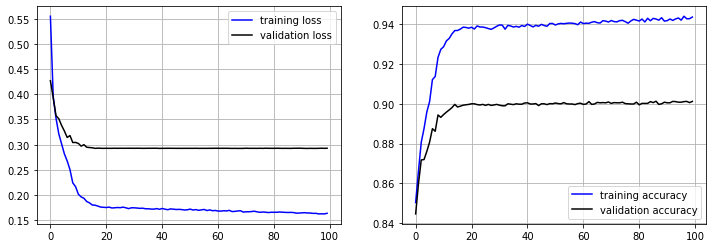

In [13]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(range(100), losses, c = 'blue', label = 'training loss')
plt.plot(range(100), val_losses, c = 'black', label = 'validation loss')
plt.grid(True)
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(range(100), accuracies, c = 'blue', label = 'training accuracy')
plt.plot(range(100), val_accuracies, c = 'black', label = 'validation accuracy')
plt.grid(True)
plt.legend()

In [14]:
for params in my_model.parameters():
    print(params.shape)

torch.Size([1000, 784])
torch.Size([1000])
torch.Size([1000])
torch.Size([1000])
torch.Size([10, 1000])
torch.Size([10])


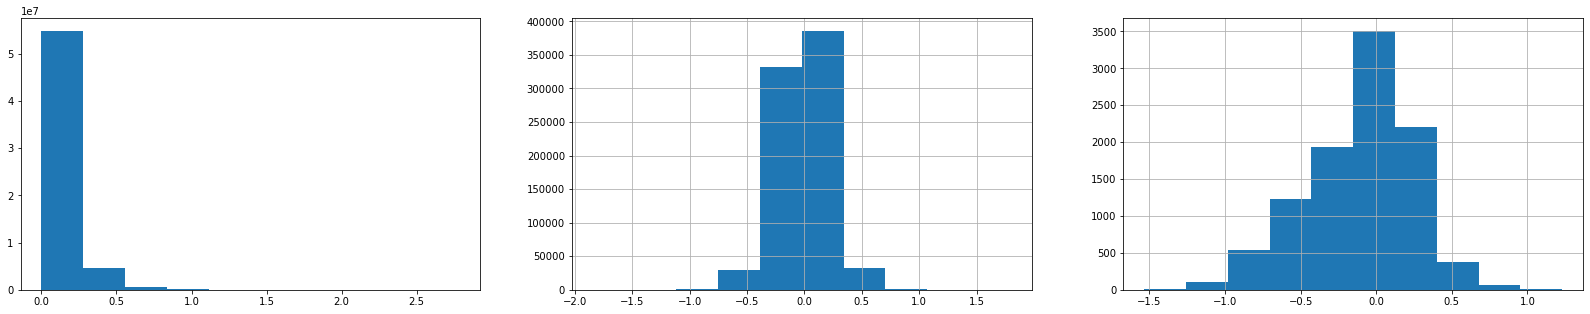

In [32]:
fig = plt.figure(figsize = (28, 5))

plt.subplot(1, 3, 1)
train_set = MyFMNISTDataset(tr_images, tr_targets)
plt.hist(my_model(train_set.x)[1].cpu().detach().numpy().flatten())

for idx, params in enumerate(iter(my_model.parameters())):
    
    if idx == 0:
        # print('The weights of the first layer distribution : \n', params.cpu().detach().numpy())
        plt.subplot(1, 3, 2)
        plt.hist(params.cpu().detach().numpy().flatten())
        plt.grid(True)
        
    # elif idx == 1:
    #     # print('The biases of the first layer distribution : \n', params.cpu().detach().numpy())
    #     plt.subplot(1, 4, idx+1)
    #     plt.hist(params.cpu().detach().numpy().flatten())
    #     plt.grid(True)
    #     
    # elif idx == 2:
    #     # print('The weights of the output layer distribution : \n', params.cpu().detach().numpy())
    #     plt.subplot(1, 4, idx+1)
    #     plt.hist(params.cpu().detach().numpy().flatten())
    #     plt.grid(True)
        
    if idx == 4:
        # print('The biases of the output layer distribution : \n', params.cpu().detach().numpy())
        plt.subplot(1, 3, 3)
        plt.hist(params.cpu().detach().numpy().flatten())
        plt.grid(True)